Set-up

In [23]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import numpy as np
#Setting up Environment

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the punkt_tab model

[nltk_data] Downloading package punkt to /Users/animesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/animesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/animesh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [25]:

dictionary = set()
try:
    with open('dictionary.txt', 'r') as file:
        for line in file:
            dictionary.add(line.strip())
    print(f"Loaded {len(dictionary)} words into the dictionary.")
except FileNotFoundError:
    print("Dictionary file not found. Proceeding without it.")


stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text, dictionary=None):
    """
    Cleans and preprocesses the text.
    - Converts text to lowercase
    - Removes punctuation
    - Tokenizes
    - Removes stopwords
    - Stems words
    - Keeps words that exist in the dictionary (if provided)
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    if dictionary:
        processed_words = [stemmer.stem(word) for word in filtered_tokens if word in dictionary]
    else:
        processed_words = [stemmer.stem(word) for word in filtered_tokens]

    return ' '.join(processed_words)


train_data = pd.read_csv("TrainData.csv")
test_data = pd.read_csv("TestData.csv")

# Preprocessing
train_data["Preprocessed_Text"] = train_data["Text"].apply(lambda x: preprocess_text(x, dictionary))
test_data["Preprocessed_Text"] = test_data["Text"].apply(lambda x: preprocess_text(x, dictionary))


train_data.to_csv("preprocessed_train.csv", index=False)
test_data.to_csv("preprocessed_test.csv", index=False)

print("Preprocessing Complete!")



Loaded 1000 words into the dictionary.
Preprocessing Complete!


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Preprocessed data
train_data = pd.read_csv("preprocessed_train.csv")
test_data = pd.read_csv("preprocessed_test.csv")

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data["Preprocessed_Text"])
X_test_tfidf = tfidf_vectorizer.transform(test_data["Preprocessed_Text"])

# Saving TF-IDF transformed data for modeling
pickle.dump(X_train_tfidf, open("X_train_tfidf.pkl", "wb"))
pickle.dump(X_test_tfidf, open("X_test_tfidf.pkl", "wb"))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", "wb"))

print("\nTF-IDF transformation complete!")



TF-IDF transformation complete!


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

X_train_tfidf = pickle.load(open("X_train_tfidf.pkl", "rb"))
X_test_tfidf = pickle.load(open("X_test_tfidf.pkl", "rb"))
train_data = pd.read_csv("preprocessed_train.csv")


y_train = train_data["Category"]

# Spliting data into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)

# Training Decision Tree Model
criteria = ["gini", "entropy"]
results = {}

for criterion in criteria:
    dt_model = DecisionTreeClassifier(criterion=criterion, random_state=42)
    dt_model.fit(X_train, y_train)
    
   
    train_acc = accuracy_score(y_train, dt_model.predict(X_train))
    val_acc = accuracy_score(y_val, dt_model.predict(X_val))
    
    results[criterion] = {"Train Accuracy": train_acc, "Validation Accuracy": val_acc}

# Results
for criterion, acc in results.items():
    print(f"\nCriterion: {criterion}")
    print(f"Train Accuracy: {acc['Train Accuracy']:.4f}")
    print(f"Validation Accuracy: {acc['Validation Accuracy']:.4f}")

# Saving the best model
best_criterion = max(results, key=lambda x: results[x]["Validation Accuracy"])
best_dt_model = DecisionTreeClassifier(criterion=best_criterion, random_state=42)
best_dt_model.fit(X_train, y_train)

pickle.dump(best_dt_model, open("decision_tree_model.pkl", "wb"))
print(f"\nBest Decision Tree model saved using '{best_criterion}' criterion.")



Criterion: gini
Train Accuracy: 1.0000
Validation Accuracy: 0.7300

Criterion: entropy
Train Accuracy: 1.0000
Validation Accuracy: 0.6700

Best Decision Tree model saved using 'gini' criterion.


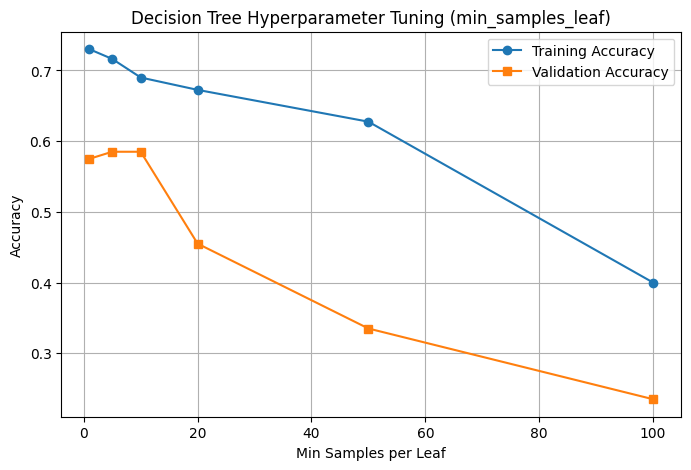

In [35]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define the range of min_samples_leaf values to test
leaf_values = [1, 5, 10, 20, 50, 100]
train_scores = []
val_scores = []

# Perform 5-fold cross-validation for each min_samples_leaf value
for leaf in leaf_values:
    dt_model = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=leaf, random_state=42)
    
    # Compute training accuracy using cross-validation
    train_acc = cross_val_score(dt_model, X_train, y_train, cv=5, scoring="accuracy")
    val_acc = cross_val_score(dt_model, X_val, y_val, cv=5, scoring="accuracy")
    
    # Store average accuracy scores
    train_scores.append(train_acc.mean())
    val_scores.append(val_acc.mean())

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(leaf_values, train_scores, marker='o', label="Training Accuracy")
plt.plot(leaf_values, val_scores, marker='s', label="Validation Accuracy")
plt.xlabel("Min Samples per Leaf")
plt.ylabel("Accuracy")
plt.title("Decision Tree Hyperparameter Tuning (min_samples_leaf)")
plt.legend()
plt.grid()
plt.show()


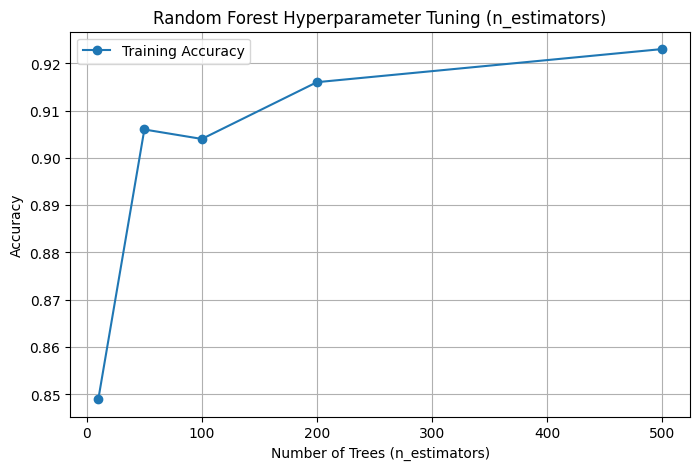


✅ Best Random Forest model saved using 500 trees.


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pickle

# Load training data and labels
X_train_tfidf = pickle.load(open("X_train_tfidf.pkl", "rb"))
train_data = pd.read_csv("preprocessed_train.csv")
y_train = train_data["Category"]

# Define the range of number of trees (n_estimators) to test
tree_values = [10, 50, 100, 200, 500]
train_scores = []
val_scores = []

# Perform 5-fold cross-validation for each value of n_estimators
for n_trees in tree_values:
    rf_model = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    
    # Compute accuracy using cross-validation
    train_acc = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, scoring="accuracy")
    
    # Store average accuracy scores
    train_scores.append(train_acc.mean())

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(tree_values, train_scores, marker='o', label="Training Accuracy")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest Hyperparameter Tuning (n_estimators)")
plt.legend()
plt.grid()
plt.show()

# Train the best model based on highest accuracy
best_n_estimators = tree_values[train_scores.index(max(train_scores))]
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
best_rf_model.fit(X_train_tfidf, y_train)

# Save the trained model
pickle.dump(best_rf_model, open("random_forest_model.pkl", "wb"))
print(f"\n✅ Best Random Forest model saved using {best_n_estimators} trees.")


In [20]:
import pickle
import pandas as pd

# Load the test data and the trained model
X_test_tfidf = pickle.load(open("X_test_tfidf.pkl", "rb"))
test_data = pd.read_csv("preprocessed_test.csv")

# Load the best trained Random Forest model
best_rf_model = pickle.load(open("random_forest_model.pkl", "rb"))

# Predict labels for the test dataset
predictions = best_rf_model.predict(X_test_tfidf)

# Prepare the output CSV file (ArticleId, PredictedLabel)
output_df = pd.DataFrame({"ArticleId": test_data["ArticleId"], "PredictedLabel": predictions})

# Save the predictions to labels.csv (without header)
output_df.to_csv("labels.csv", index=False, header=False)

print("\n✅ Predictions saved to 'labels.csv'. Ready for submission!")



✅ Predictions saved to 'labels.csv'. Ready for submission!
